In [1]:
import numpy as np
import random
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

# let's make some data

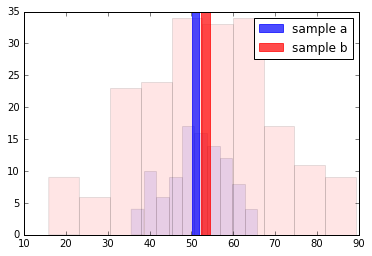

In [18]:
a = np.random.normal(50.,7.4,size=100)
b = np.random.normal(53.5,15.9,size=200)
fig,ax = plt.subplots()
ax.hist(a,color='blue',alpha=0.1)
ax.hist(b,color='red',alpha=0.1)
ax.axvspan(a.mean()-a.std()/np.sqrt(a.size),a.mean()+a.std()/np.sqrt(a.size),color='blue',alpha=0.7,label='sample a')
ax.axvspan(b.mean()-b.std()/np.sqrt(b.size),b.mean()+b.std()/np.sqrt(b.size),color='red', alpha=0.7,label='sample b')
ax.legend()

## parametric independent t test with equal variance assumption

In [19]:
stats.ttest_ind(a,b,equal_var=True,)

Ttest_indResult(statistic=-1.4235509465611305, pvalue=0.15562264190999237)

## parametric independent t test without equal variance assumption

In [20]:
stats.ttest_ind(a,b,equal_var=False,)

Ttest_indResult(statistic=-1.7871943756590956, pvalue=0.074933023499128962)

## nonparametric t test using scipy

In [21]:
stats.mannwhitneyu(a,b,)

MannwhitneyuResult(statistic=8865.0, pvalue=0.054604576810709037)

## nonparametric t test by permutation test

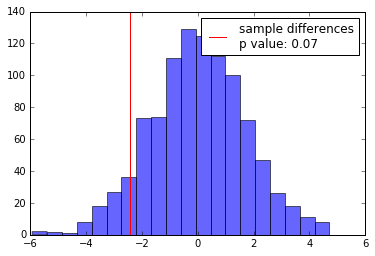

In [22]:
fig, ax = plt.subplots()
difference = np.mean(a) - np.mean(b)
results=[]
for ii in range(1000):
    c = np.concatenate([a,b])
    random.shuffle(c)
    new_a = c[:100]
    new_b = c[100:]
    new_diff = new_a.mean() - new_b.mean()
    results.append(new_diff)
results = np.array(results)
ax.hist(results,color='blue',alpha=0.6,bins=20)
p = min([stats.percentileofscore(results,difference,)/100,1-stats.percentileofscore(results,difference,)/100])
ax.axvline(difference,color='red',label='sample differences\np value: %.2f'%p)
ax.legend()

## redo the permutation test multiple times and sample the distribution of the p values

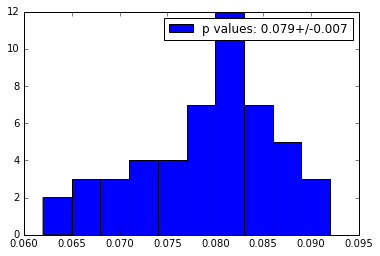

In [23]:
results = []
for ii in range(50):
    temp=[]
    for jj in range(1000):
        c = np.concatenate([a,b])
        random.shuffle(c)
        new_a = c[:100]
        new_b = c[100:]
        new_diff = new_a.mean() - new_b.mean()
        temp.append(new_diff)
    temp = np.array(temp)
    p=min([stats.percentileofscore(temp,difference,)/100,1-stats.percentileofscore(temp,difference,)/100])
    results.append(p)
fig, ax = plt.subplots()
ax.hist(results,bins=10,label='p values: %.3f+/-%.3f'%(np.mean(results),np.std(results)))
ax.legend(loc='best')

# Bayesian stats

In [24]:
import pymc3 as pm

In [40]:
c = np.concatenate([a,b])
c_m = c.mean()
c_s = c.std()*2
with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', c_m, sd=c_s)
    group2_mean = pm.Normal('group2_mean', c_m, sd=c_s)

In [41]:
σ_low = 5
σ_high = 17

with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)

In [42]:
with model:
    v = pm.Exponential('v_minus_one',1/29.) +1

In [43]:
with model:
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=v, mu=group1_mean, lam=λ1, 
                         observed=a)
    group2 = pm.StudentT('placebo', nu=v, mu=group2_mean, lam=λ2, 
                         observed=b)

In [44]:
with model:
    diff_of_means = pm.Deterministic('difference of means', 
                                     group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', 
                                    group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))

In [ ]:
with model:
    trace = pm.sample(2000,init=None,njobs=1)

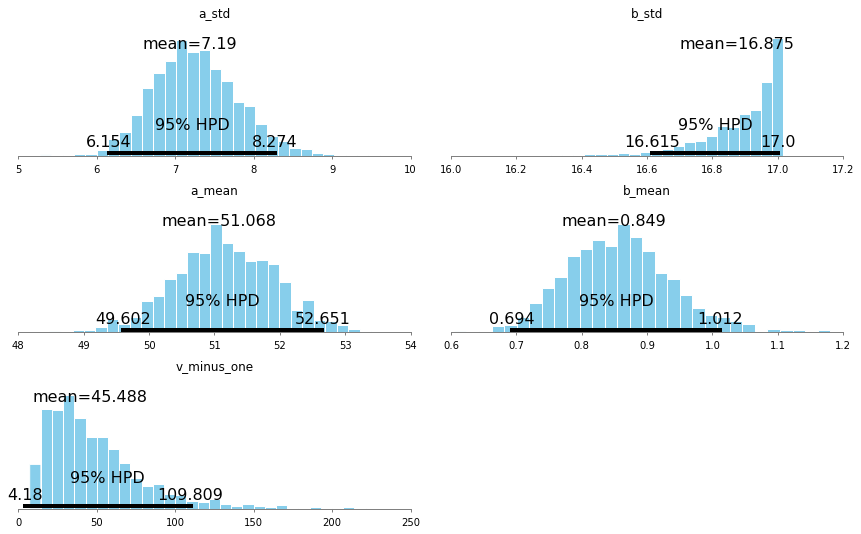

In [31]:
_=pm.plot_posterior(trace[100:],
                 varnames=['a_std','b_std',
                          'a_mean','b_mean',
                          'v_minus_one'],
                 color='#87ceeb')

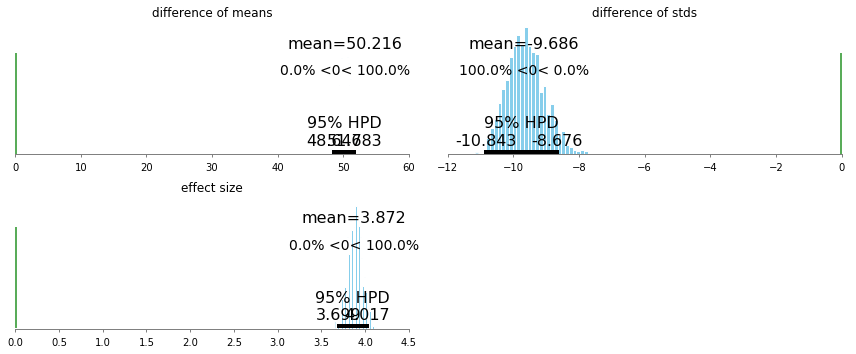

In [32]:
_=pm.plot_posterior(trace[1000:],
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')

In [ ]:
_=pm.forestplot(trace[1000:], 
                varnames=[v.name for v in model.vars[:2]])